## Notebook for example of multilooking and filtering

In [26]:
from matplotlib import rc
import rasterio
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from rasterio.enums import Resampling
import scipy.ndimage
import geopandas as gpd
from rasterio.plot import show
from shapely.geometry import box

In [18]:
# Add MiKTeX bin directory to PATH
os.environ['PATH'] += os.pathsep + r'C:\Users\olive\AppData\Local\Programs\MiKTeX\miktex\bin\x64'

# Verify the update
print("Updated PATH:")
print(os.environ['PATH'])

# Print LaTeX configuration
print("LaTeX configuration:")
print(os.popen("latex --version").read())


Updated PATH:
c:\Users\olive\AppData\Local\Programs\Python\Python311;c:\Users\olive\AppData\Roaming\Python\Python311\Scripts;C:\Program Files\Common Files\Oracle\Java\javapath;C:\Program Files (x86)\Common Files\Oracle\Java\java8path;C:\Program Files (x86)\Common Files\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\Git\cmd;C:\Program Files\dotnet\;C:\Program Files\Pandoc\;C:\Users\olive\AppData\Local\Programs\Python\Python311;C:\Users\olive\AppData\Local\Programs\Python\Python311\Scripts;C:\Users\olive\AppData\Local\Programs\MiKTeX\miktex\bin\x64;C:\Users\olive\AppData\Local\Programs\Python\Python311\Scripts;C:\Users\olive\AppData\Local\Programs\Python\Python311;C:\Users\olive\AppData\Local\Microsoft\WindowsApps;C:\Users\olive\AppData\Local\Programs\Microsoft VS Code\bin;C:\Program Files\esa-snap\bin;C:\Users\olive\AppData\Local\Programs\MiKTeX\miktex\bin\x64\;C:\Prog

In [19]:
# Set specific font sizes
plt.rcParams.update({
    'font.size': 12,          # Global font size
    'axes.titlesize': 11,     # Title font size
    'axes.labelsize': 11,     # X and Y axis labels font size
    'xtick.labelsize': 9,    # X-axis tick labels font size
    'ytick.labelsize': 9,    # Y-axis tick labels font size
    'legend.fontsize': 10,    # Legend font size
})
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

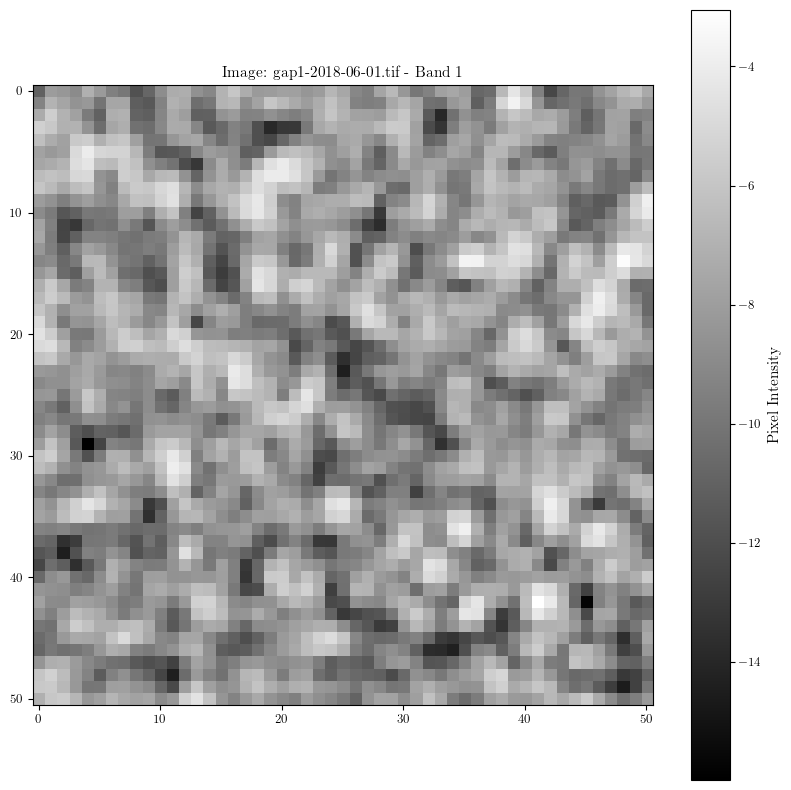

In [20]:
# Define the filepath
folder_path = 'downld_2yr_12dayinterval/gap1'

# List all the .tif files in the directory
tif_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

# Select the first file
first_tif = os.path.join(folder_path, tif_files[0])

# Open the first .tif image
with rasterio.open(first_tif) as src:
    # Read the first band
    band1 = src.read(1)
    
    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(band1, cmap='gray')
    plt.title(f'Image: {tif_files[0]} - Band 1')
    plt.colorbar(label='Pixel Intensity')
    plt.show()


In [39]:
def lee_filter(image, window_size=3):
    # Calculate the mean and variance within the window
    mean_window = scipy.ndimage.uniform_filter(image, window_size)
    mean_sq_window = scipy.ndimage.uniform_filter(image**2, window_size)
    var_window = mean_sq_window - mean_window**2

    # Calculate the overall variance of the image
    overall_var = np.var(image)

    # Apply the Lee filter formula
    lee_filtered_image = mean_window + var_window / (var_window + overall_var) * (image - mean_window)
    
    return lee_filtered_image

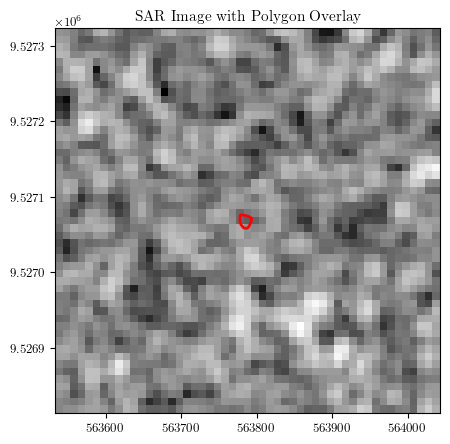

In [72]:
# Path to the GeoPackage or Shapefile
polygon_file = 'polygon1.gpkg'  # Replace with your file path
# If you're using a Shapefile, use 'path_to_your_file.shp'

# Read the polygons from the GeoPackage
gdf = gpd.read_file(polygon_file)

# Define the filepath of the .tif image
folder_path = 'downld_2yr_12dayinterval/gap4'
tif_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]
tif_files.sort()  # Sort to ensure proper order

# Select the first file to open
tif_file = os.path.join(folder_path, tif_files[5])

# Open the .tif image and get its bounding box
with rasterio.open(tif_file) as src:
    image_bounds = src.bounds
    image_crs = src.crs  # Get the CRS of the image
    
    # Convert the bounding box to a shapely polygon
    image_bbox = box(*image_bounds)

    # Reproject the GeoDataFrame to match the CRS of the image (if necessary)
    if gdf.crs != image_crs:
        gdf = gdf.to_crs(image_crs)
    
    # Filter polygons that intersect with the image bounding box
    filtered_gdf = gdf[gdf.intersects(image_bbox)]

    # Plot the SAR image
    fig, ax = plt.subplots(figsize=(5, 5))
    show(src, ax=ax, cmap='gray')

    # Plot the filtered polygons on top
filtered_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2)

plt.title('SAR Image with Polygon Overlay')
plt.show()


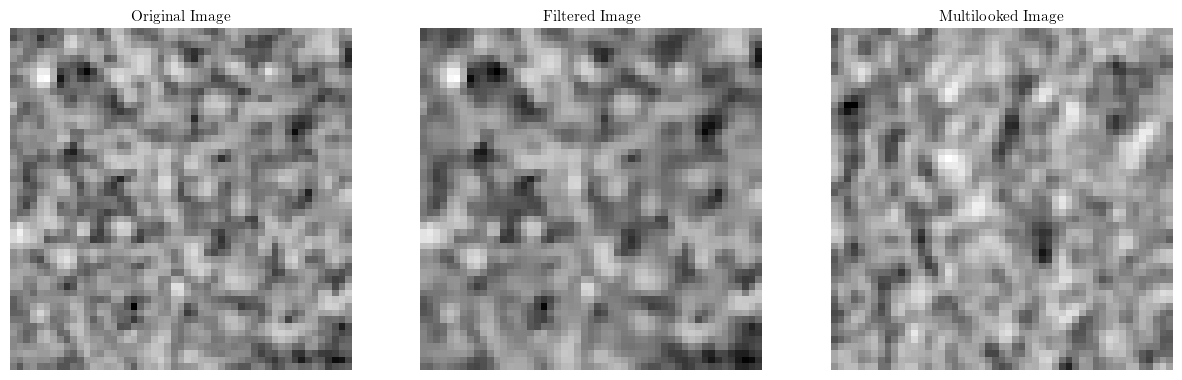

In [71]:
# Define the filepath
folder_path = 'downld_2yr_12dayinterval/gap1'

# List all the .tif files in the directory
tif_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]
tif_files.sort()  # Sort to ensure proper order

# Select the first file to open
first_tif = os.path.join(folder_path, tif_files[5])

# Open the first .tif image to get reference dimensions
with rasterio.open(first_tif) as src:
    band1 = src.read(1)  # Read the first band
    reference_shape = band1.shape  # Get the shape of the reference image

# Apply a Gaussian filter (for smoothing)
lee_filtered_band = lee_filter(band1)

# Perform multilooking by averaging the first 10 images in the folder
n_images = min(20, len(tif_files))
multilook_band = np.zeros(reference_shape, dtype=np.float32)

for i in range(n_images):
    with rasterio.open(os.path.join(folder_path, tif_files[i])) as src:
        # Read and resize the image to match the reference shape
        band = src.read(1, out_shape=reference_shape, resampling=Resampling.bilinear)
        multilook_band += band

multilook_band /= n_images  # Average the images

# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
axs[0].imshow(band1, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

# Filtered Image
axs[1].imshow(lee_filtered_band, cmap='gray')
axs[1].set_title('Filtered Image')
axs[1].axis('off')

# Multilooked Image
axs[2].imshow(multilook_band, cmap='gray')
axs[2].set_title('Multilooked Image')
axs[2].axis('off')

plt.show()


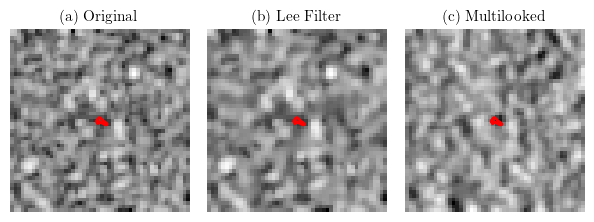

In [95]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show
from shapely.geometry import box
from rasterio.enums import Resampling

# Path to the GeoPackage or Shapefile
polygon_file = 'polygon1.gpkg'  # Replace with your file path

# Read the polygons from the GeoPackage
gdf = gpd.read_file(polygon_file)

# Define the filepath of the .tif image
folder_path = 'downld_2yr_12dayinterval/gap5'
tif_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]
tif_files.sort()  # Sort to ensure proper order

# Select the first file to open
tif_file = os.path.join(folder_path, tif_files[5])

# Open the .tif image and get its bounding box
with rasterio.open(tif_file) as src:
    image_bounds = src.bounds
    image_crs = src.crs  # Get the CRS of the image
    transform = src.transform  # Get the affine transform

    # Convert the bounding box to a shapely polygon
    image_bbox = box(*image_bounds)

    # Reproject the GeoDataFrame to match the CRS of the image (if necessary)
    if gdf.crs != image_crs:
        gdf = gdf.to_crs(image_crs)
    
    # Filter polygons that intersect with the image bounding box
    filtered_gdf = gdf[gdf.intersects(image_bbox)]

    # Extract the first band for further processing
    band1 = src.read(1)

# Apply the Lee filter (assuming it's already available in your environment)
lee_filtered_band = lee_filter(band1)

# Perform multilooking by averaging the first 10 images in the folder
n_images = min(20, len(tif_files))
multilook_band = np.zeros(band1.shape, dtype=np.float32)

for i in range(n_images):
    with rasterio.open(os.path.join(folder_path, tif_files[i])) as src:
        band = src.read(1, out_shape=band1.shape, resampling=Resampling.bilinear)
        multilook_band += band

multilook_band /= n_images  # Average the images

# Function to manually plot GeoDataFrame boundaries
def plot_polygon(ax, gdf, transform):
    for _, row in gdf.iterrows():
        geom = row.geometry
        if geom.geom_type == 'Polygon':
            exterior_coords = np.array(geom.exterior.coords)
            xs, ys = zip(*[~transform * coord for coord in exterior_coords])
            ax.plot(xs, ys, color='red', linewidth=2)
        elif geom.geom_type == 'MultiPolygon':
            for part in geom:
                exterior_coords = np.array(part.exterior.coords)
                xs, ys = zip(*[~transform * coord for coord in exterior_coords])
                ax.plot(xs, ys, color='red', linewidth=2)

# Plotting the results in a strip
fig, axs = plt.subplots(1, 3, figsize=(6.1, 2.4))

# Plot 1: Original SAR Image with Polygon Overlay
show(band1, ax=axs[0], cmap='gray')
plot_polygon(axs[0], filtered_gdf, transform)
axs[0].set_title('(a) Original')
axs[0].axis('off')  # Turn off axis

# Plot 2: Filtered SAR Image with Polygon Overlay
axs[1].imshow(lee_filtered_band, cmap='gray')
plot_polygon(axs[1], filtered_gdf, transform)
axs[1].set_title('(b) Lee Filter')
axs[1].axis('off')  # Turn off axis

# Plot 3: Multilooked SAR Image with Polygon Overlay
axs[2].imshow(multilook_band, cmap='gray')
plot_polygon(axs[2], filtered_gdf, transform)
axs[2].set_title('(c) Multilooked')
axs[2].axis('off')  # Turn off axis

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('images_filter_multilook_comparison.pdf')
plt.show()